# ECE 475 Frequentist Machine Learning Assignment 2
Yingzhi Hao & Crystal Wang

# Pre-processing Data


In [ ]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import warnings
import seaborn
from sklearn import linear_model
from datetime import datetime
from numpy.linalg import inv


class Data(object):
    def __init__(self, data_frame):
        self.df = data_frame
        self.column_name = self.df.columns

    @staticmethod
    def scaler(input_df):
        """Normalize data by subtracting the mean and being divided by the variance."""
        # return input_df.subtract(input_df.mean()).divide(input_df.std(ddof=0))
        return (input_df-input_df.min())/(input_df.max()-input_df.min())

    def get_data_train(self, add_prefix, target_label):
        length = int(0.8*len(self.df))
        data_training = Data.scaler(self.df[:length].drop(labels=[target_label], axis=1))
        # data_target = Data.scaler(self.df[target_label][:length])
        data_target = self.df[target_label][:length]
        data_training.insert(loc=data_training.shape[1], column=target_label, value=data_target)
        prefix = pd.DataFrame(data=np.full((length, 1), 1))
        if add_prefix:
            data_training.insert(loc=0, column="prefix", value=prefix)
        return np.array(data_training)

    def get_data_test(self, add_prefix, target_label):
        length_min = int(0.8 * len(self.df))
        length_max = int(0.9 * len(self.df))
        data_testing = Data.scaler(self.df[length_min:length_max].drop(labels=[target_label], axis=1))
        # data_target = Data.scaler(self.df[target_label][length_min:length_max])
        data_target = self.df[target_label][length_min:length_max]
        data_testing.insert(loc=data_testing.shape[1], column=target_label, value=data_target)
        prefix = np.ones((data_testing.shape[0], 1))
        if add_prefix:
            data_testing.insert(loc=0, column="prefix", value=prefix)
        return np.array(data_testing)

    def get_data_validation(self, add_prefix, target_label):
        length_min = int(0.9 * len(self.df))
        data_validation = Data.scaler(self.df[length_min:].drop(labels=[target_label], axis=1))
        # data_target = Data.scaler(self.df[target_label][length_min:])
        data_target = self.df[target_label][length_min:]
        data_validation.insert(loc=data_validation.shape[1], column=target_label, value=data_target)
        prefix = np.ones((data_validation.shape[0], 1))
        if add_prefix:
            data_validation.insert(loc=0, column="prefix", value=prefix)
        return np.array(data_validation)

    def get_correlation(self, label_a, label_b):
        """Given two labels, calculate the correlation between the two labelled columns."""
        length = len(self.df)
        x = np.array(self.df[label_a][:length])
        y = np.array(self.df[label_b][:length])
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        result = np.dot(x-x_mean, y-y_mean)/length / math.sqrt(np.var(x) * np.var(y))
        return result


In [ ]:
def load_dataset_1():
    url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data'
    df = pd.read_csv(url, sep=",")
    df.drop(df.columns[0], axis=1, inplace=True)
    mapping = {'Present': 1, 'Absent': 0}
    df = df.replace({'famhist': mapping})
    return df


def sigmoid(num):
    return 1 / (1 + math.exp(-num))


def accuracy_test(theta, x, y):
    prediction = [int(round(sigmoid(label_prediction(theta, row)))) for row in x]
    num_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == y[i]:
            num_correct += 1
    return num_correct / len(prediction)




# Part 1 - Logistic Regression W/O L2 Penalty


Logistic Regression weight function is from http://cs229.stanford.edu/notes/cs229-notes1.pdf section 5: logistic regression. L2 penalty stubtracted  a [lamba * theta * transpose(theta)] during the update on each weight

In [ ]:
def get_baseline(trainData, testData):
    label_training = np.array(trainData[:,-1], dtype = 'int64')
    label_testing = testData[:,-1]
    count = np.bincount(label_training)
    baseLabel = np.argmax(count)
    accuracy = (baseLabel == label_testing).sum().astype(np.float128)/len(label_testing)
    print("BaseLine accuracy: ",accuracy)
    return accuracy

def label_prediction(theta, x):
    h = 1 / (1 + np.exp(-np.dot(np.transpose(theta), x)))
    return h

def sgd_basic(feature, err, learning_rate, weight):
    """Update weight using basic stochastic gradient descent."""
    weight = weight + learning_rate * err * feature
    return weight

def sgd_training(data, learning_rate, n_epoch):
    theta = [0.0] * (data.shape[1] - 1)
    feature = data[:, 0:-1]
    label = data[:, -1]
    for n in range(n_epoch):
        # Iterate through every weight
        for j in range(feature.shape[1]):
            index = random.randint(0, feature.shape[0]-1)
            prediction = label_prediction(theta, feature[index])
            err = label[index] - int(round(sigmoid(prediction)))
            theta = sgd_basic(feature[index], err, learning_rate, theta)
    return theta

def sgd_validation_L2(dataTrain, dataValid, learning_rate, n_epoch):
    N = 50
    lamb = np.logspace(-20, 1, N)
    featureTrain = dataTrain[:, 0:-1]
    labelTrain = dataTrain[:, -1]
    featureValid = dataValid[:, 0:-1]
    labelValid = dataValid[:, -1]
    row, col = np.shape(featureTrain)
    accuracy = 0
    thetaL2 = []
    optimalLambda = 0
    for l in range(N):
      theta = np.zeros(col)
      for n in range(n_epoch):
        index = list(range(row))
        # the current row 
        current = 0
        while current < row:  
          rand  = int(np.random.uniform(0,index.__len__()))
          xTrainR = featureTrain[index[rand]]

          h = label_prediction(theta, xTrainR)
          gradient = np.dot((labelTrain[index[rand]] - h), xTrainR)

          theta += learning_rate * gradient - 2 * lamb[l] * theta * np.transpose(theta)

          # Deleting the observation that has been used in this epoch
          del(index[rand])
          current += 1
      
      z = np.dot(featureValid, np.transpose(theta))
      prediction = np.round(1/(1+np.exp(-z)))
      accuracyEach = (prediction == labelValid).sum().astype(np.float64)/len(prediction)
      
      if accuracyEach > accuracy:
        accuracy = accuracyEach
        optimalLambda = lamb[l]
        thetaL2 = theta
    
    print("Optimal Lambda:", optimalLambda)
    # print("Optimal Theta: ", thetaL2)
    print("L2 Accuracy:", accuracy)
    return  accuracy, thetaL2
  
def logistic_regression(data):
    data_train = data.get_data_train(True, "chd")
    data_validation = data.get_data_validation(True, "chd")
    data_test = data.get_data_test(True, "chd")
    learning_rate = 0.05
    n_epoch = 1500
    baselineAccuracy = get_baseline(data_train, data_test)
    theta = sgd_training(data_train, learning_rate, n_epoch)
    accuracy = accuracy_test(theta, data_test[:, 0:-1], data_test[:, -1])
    print("Test Accuracy with unregularized sgd: ", accuracy)
    accuracyL2, thetaL2 = sgd_validation_L2(data_train, data_validation,learning_rate, n_epoch)
    accuracyL1, lasso = logistic_regression_L1(data_train, data_validation, learning_rate, n_epoch)
    accuracyStep = logistic_regression_foward_step(data)
    print("Forward-step regression: ", accuracyStep)
    approach = ['Baseline', 'Unregularized', 'with L2 penalty', 'with L1 pentalty', 'Forward Stepwise']
    correctness = [baselineAccuracy, accuracy, accuracyL2, accuracyL1,accuracyStep]
    tableCorrectness = pd.DataFrame(correctness,approach)
    print('% correctness for different approach of logistic regression')
    display(tableCorrectness)


L1 Penalty equation is from  https://www.aclweb.org/anthology/P09-1054.pdf section 3.1

In [ ]:
def logistic_regression_L1(dataTrain, dataValid, learning_rate, n_epoch):
    N = 50
    lamb = np.linspace(0, 0.1, N)
    featureTrain = dataTrain[:, 0:-1]
    labelTrain = dataTrain[:, -1]
    featureValid = dataValid[:, 0:-1]
    labelValid = dataValid[:, -1]
    row, col = np.shape(featureTrain)
    accuracy = 0
    thetaL1 = []
    optimalLambda = 0
    lasso = np.zeros((N, col))
    for l in range(N):
      theta = np.zeros(col)
      for n in range(n_epoch):
        index = list(range(row))
        # the current row 
        current = 0
        while current < row:  
          rand  = int(np.random.uniform(0,index.__len__()))
          xTrainR = featureTrain[index[rand]]

          h = label_prediction(theta, xTrainR)
          gradient = np.dot((labelTrain[index[rand]] - h), xTrainR)
          theta += learning_rate * gradient
          for i in range(len(theta)):
            if theta[i] < 0:
              theta[i] =  min(0, theta[i] + lamb[l] * learning_rate)
            elif theta[i] > 0:
              theta[i] =  max(0, theta[i] - lamb[l] * learning_rate)

          # Deleting the observation that has been used in this epoch
          del(index[rand])
          current += 1
      
      z = np.dot(featureValid, np.transpose(theta))
      prediction = np.round(1/(1+np.exp(-z)))
      accuracyEach = (prediction == labelValid).sum().astype(np.float64)/len(prediction)
      lasso[l, :] = theta
      
      
      if accuracyEach > accuracy:
        accuracy = accuracyEach
        optimalLambda = lamb[l]
        thetaL1 = theta
    
    print("Optimal Lambda for L1:", optimalLambda)
    print("L1 Accuracy:", accuracy)

    for i in range(1, featureTrain.shape[1]):
      plt.plot(lamb, lasso[:,i])
    plt.title('L1 regularized logistic regression coefficients for the South African Heart Disease Data')
    plt.ylabel('Coefficients')
    plt.xlabel('Lambda')
    plt.legend(['sbp', 'tobacco', 'ldl','adiposity', 'famhist', 'typea', 'obesity', 'alcohol', 'age'], loc = 'upper right')
    plt.show()
    return  accuracy, thetaL1
  

# Forward Stepwise Regression

In [ ]:
def sgd_stepwise(data, data_header, learning_rate, n_epoch, data_val):
    feature = data[:, 0:-1]
    label = data[:, -1]
    feature_unselected = pd.DataFrame(data=feature, columns=data_header[0:-1])
    feature_unselected_header = list(feature_unselected.columns)
    feature_selected = pd.DataFrame(data=np.array([[1.0] * data.shape[0]]).T, columns=["prefix"])
    data_val_frame = pd.DataFrame(data=data_val, columns=data_header)
    feature_selected_val = pd.DataFrame(data=np.array(np.array([[1.0] * data_val.shape[0]]).T), columns=["prefix"])
    theta_opt = []
    accuracy_opt = 0
    while True:
        accuracy_opt_per_feature = 0
        theta_opt_per_feature = []
        feature_selected_candidate = feature_unselected_header[0]
        for header in feature_unselected_header:
            data_train = feature_selected.copy()
            data_train.insert(len(data_train.columns), header, feature_unselected[header], True)
            data_train.insert(len(data_train.columns), "label", label, True)
            theta = sgd_training(np.array(data_train), learning_rate, n_epoch)
            data_validation = feature_selected_val.copy()
            data_validation.insert(len(data_validation.columns), header, data_val_frame[header], True)
            data_validation.insert(len(data_validation.columns), "label", data_val[:, -1], True)
            accuracy = accuracy_test(theta, np.array(data_validation)[:, 0:-1], np.array(data_validation)[:, -1])
            if accuracy > accuracy_opt_per_feature:
                accuracy_opt_per_feature = accuracy
                feature_selected_candidate = header
                theta_opt_per_feature = theta
        if accuracy_opt_per_feature > accuracy_opt:
            accuracy_opt = accuracy_opt_per_feature
            theta_opt = theta_opt_per_feature
            feature_selected.insert(len(feature_selected.columns), feature_selected_candidate, feature_unselected[feature_selected_candidate], True)
            feature_selected_val.insert(len(feature_selected_val.columns), feature_selected_candidate, data_val_frame[feature_selected_candidate], True)
            del feature_unselected[feature_selected_candidate]
            feature_unselected_header.remove(feature_selected_candidate)
        else:
            break
    return theta_opt, feature_selected.columns


def logistic_regression_foward_step(data):
    data_train = data.get_data_train(False, "chd")
    data_validation = data.get_data_validation(False, "chd")
    # data_test = data.get_data_test(False, "chd")
    feature_header = list(data.column_name)
    feature_header.remove("chd")
    feature_header.append("chd")    # To make sure the label is at the end of the header list
    theta, feature_selected = sgd_stepwise(data_train, feature_header, learning_rate, n_epoch, data_validation)
    print("Select features: ")
    print(feature_selected)
    feature_unselected = pd.DataFrame(data=data_test[:, 0:-1], columns=(["prefix"]+feature_header[0:-1]))
    accuracy = accuracy_test(theta, np.array(feature_unselected[feature_selected]), data_test[:, -1])
    return accuracy


# Results

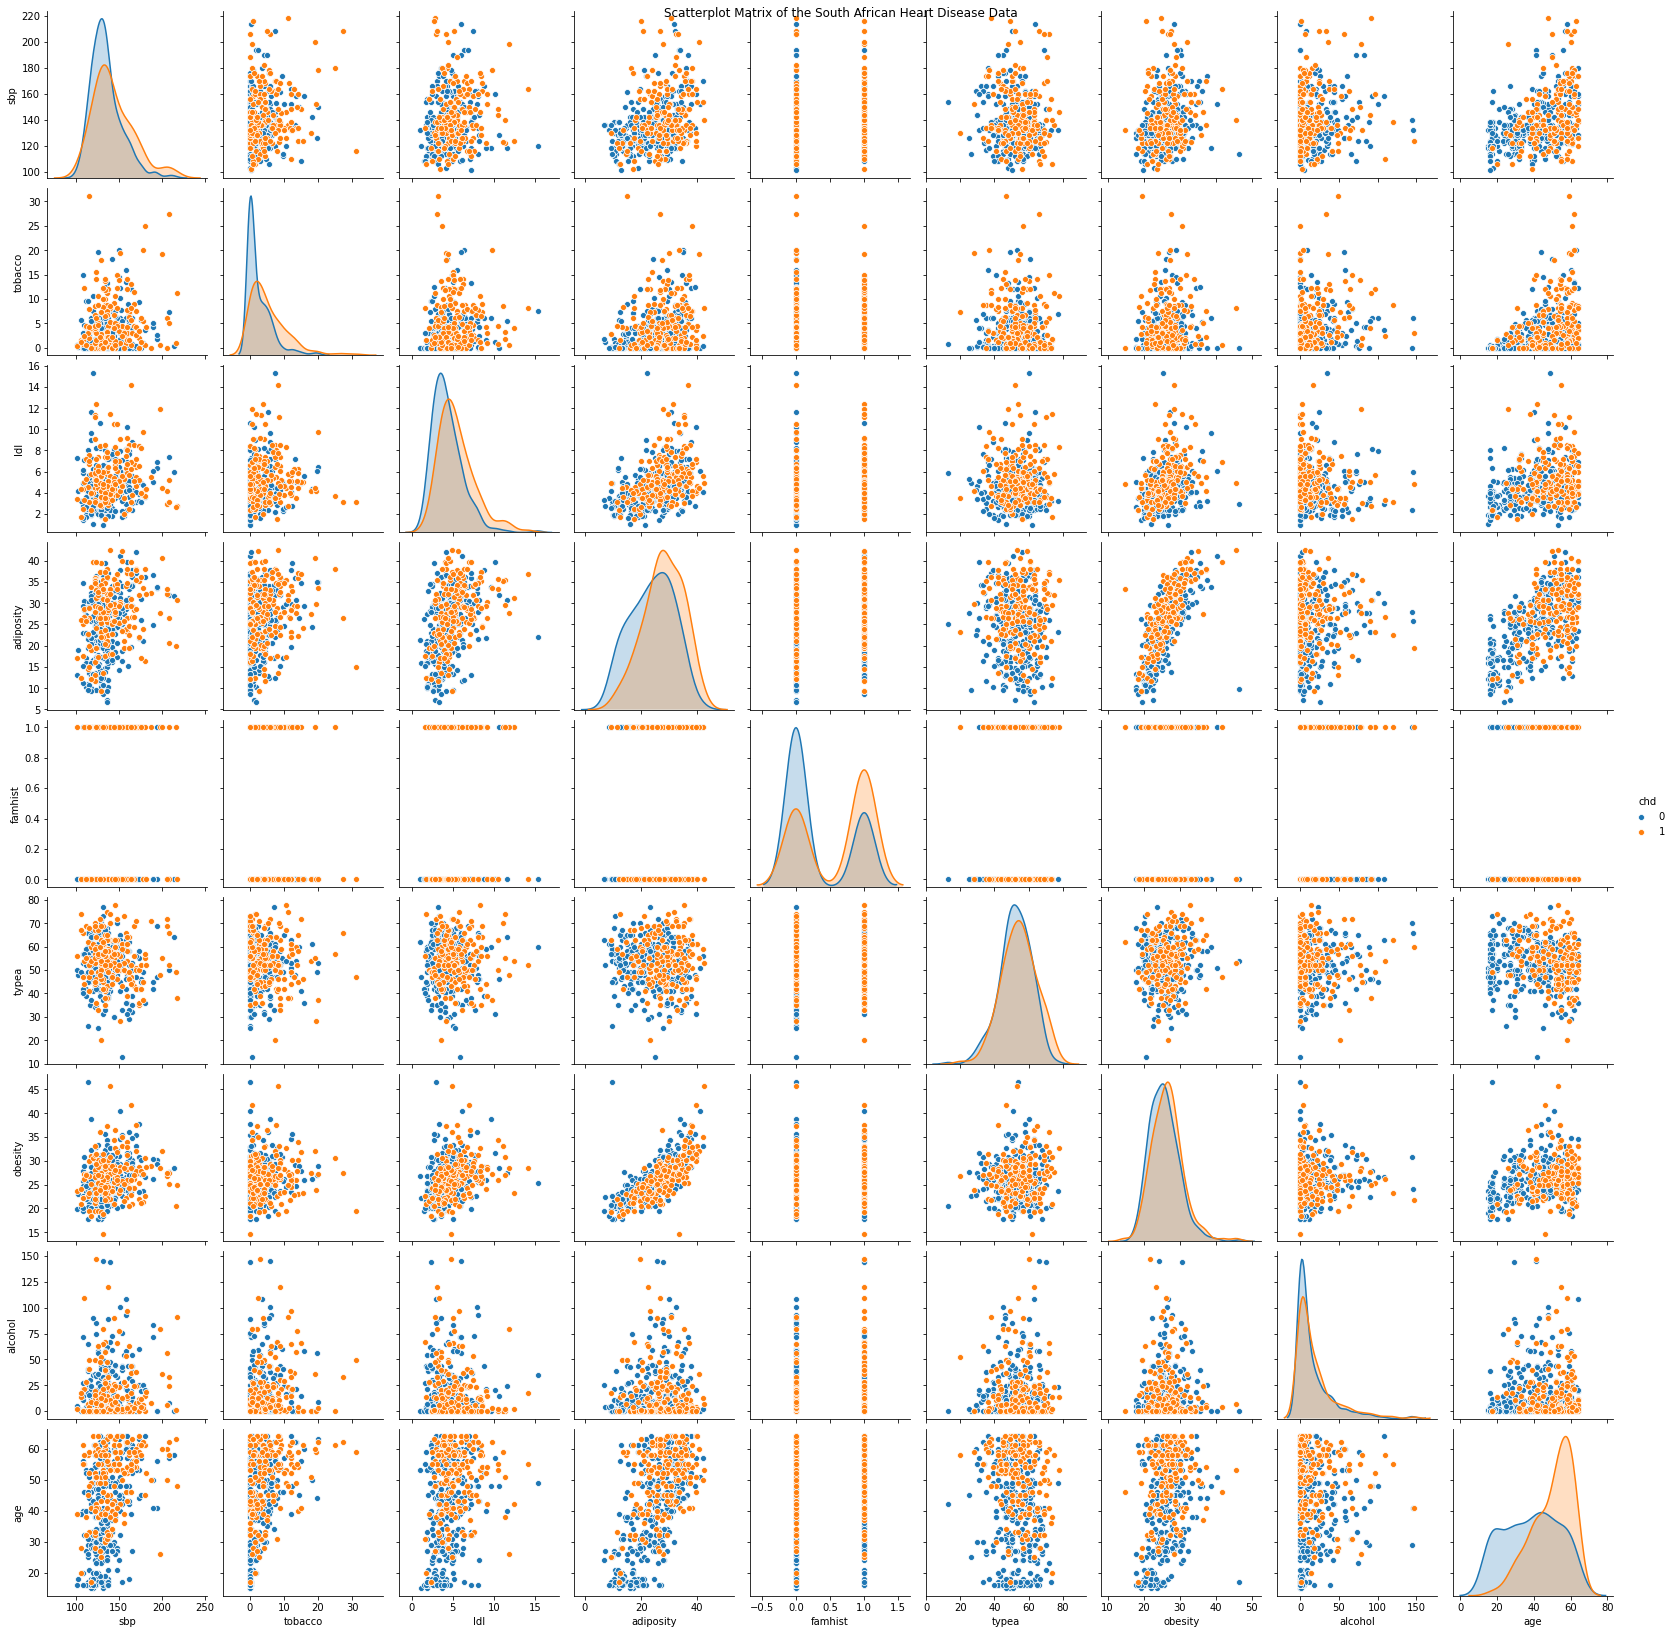

In [ ]:
warnings.filterwarnings("ignore")
random.seed(datetime.now())
df = load_dataset_1()
scatter_plot = seaborn.pairplot(df, hue = "chd")
scatter_plot.fig. suptitle("Scatterplot Matrix of the South African Heart Disease Data", y = 1)
plt.show()


BaseLine accuracy:  0.67391304347826086956
Test Accuracy with unregularized sgd:  0.7391304347826086
Optimal Lambda: 1.389495494373136e-18
L2 Accuracy: 0.7659574468085106
Optimal Lambda for L1: 0.010204081632653062
L1 Accuracy: 0.8085106382978723


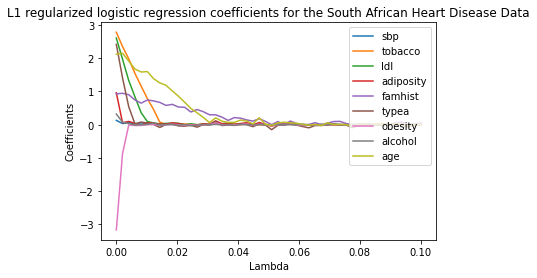

Select features: 
Index(['prefix', 'age', 'ldl'], dtype='object')
Forward-step regression:  0.7391304347826086
% correctness for different approach of logistic regression


,0
Baseline,0.673913
Unregularized,0.739130
with L2 penalty,0.765957
with L1 pentalty,0.808511
Forward Stepwise,0.739130


In [ ]:
# Uncomment this line to randomize dataset.
df = df.sample(frac=1, random_state=random.randint(0, 200)).reset_index().drop(labels=["index"], axis=1)
data = Data(df)
data_train = data.get_data_train(True, "chd")
data_validation = data.get_data_validation(True, "chd")
data_test = data.get_data_test(True, "chd")
learning_rate = 0.05
n_epoch = 1500
baselineAccuracy = get_baseline(data_train, data_test)
theta = sgd_training(data_train, learning_rate, n_epoch)
accuracy = accuracy_test(theta, data_test[:, 0:-1], data_test[:, -1])
print("Test Accuracy with unregularized sgd: ", accuracy)
accuracyL2, thetaL2 = sgd_validation_L2(data_train, data_validation,learning_rate, n_epoch)
accuracyL1, lasso = logistic_regression_L1(data_train, data_validation, learning_rate, n_epoch)
accuracyStep = logistic_regression_foward_step(data)
print("Forward-step regression: ", accuracyStep)
approach = ['Baseline', 'Unregularized', 'with L2 penalty', 'with L1 pentalty', 'Forward Stepwise']
correctness = [baselineAccuracy, accuracy, accuracyL2, accuracyL1,accuracyStep]
tableCorrectness = pd.DataFrame(correctness,approach)
print('% correctness for different approach of logistic regression')
display(tableCorrectness)
#Create a table for all the % of correctness

According to our result, all the logistic regression approach has better accuracies than the accuracy of basline. L1 pentaly performed the best of all. The lambda values for L1 and L2 are usually very small and sometimes can't see a huge difference in terms of the improvement of accuracy of this specific dataset

# Stetch Goal 2: Multi-variable logistic regression

In [ ]:
def load_dataset_2():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    df = pd.read_csv(url, header=None, names=["sepal_length", "sepal_width",
                                              "petal_length", "petal_width",
                                              "species"])
    # Map categories to numbers
    df['species'] = df['species'].astype('category').cat.codes
    return df


def sgd_multivariable(data, learning_rate, n_epoch):
    theta_list = []
    feature = data[:, 0:-1]
    label = data[:, -1]
    classes = np.unique(label)
    # Calculate theta on every class
    for single_class in classes:
        label_training = np.array([np.where(label == single_class, 1, 0)]).T
        data_training = np.append(feature, label_training, axis=1)
        theta = sgd_training(data_training, learning_rate, n_epoch)
        theta_list.append(theta)
    return theta_list


def label_prediction_multivariable(data, thetas):
    feature = data[:, 0:-1]
    label = data[:, -1]
    prediction_list = []
    for i in range(feature.shape[0]):
      # Predict on every class and select the class with the highest sigmoid score
      prediction = np.argmax([sigmoid(np.dot(feature[i], np.transpose(theta))) for theta in thetas])
      prediction_list.append(prediction)
    return np.array(prediction_list == label).mean()
    

df2 = load_dataset_2()
df2 = df2.sample(frac=1, random_state=random.randint(0, 200)).reset_index()
data2 = Data(df2)
data_train = data2.get_data_train(True, "species")
data_test = data2.get_data_test(True, "species")
theta_list = sgd_multivariable(data_train, learning_rate=0.06, n_epoch=1500)
accuracy = label_prediction_multivariable(data_test, theta_list)
accuracyTrain = label_prediction_multivariable(data_train, theta_list)
print("Muti-variable logistic regression test accuracy: ", accuracy)
print("Muti-variable logistic regression training accuracy: ", accuracyTrain)

Muti-variable logistic regression test accuracy:  0.9333333333333333
Muti-variable logistic regression training accuracy:  0.9666666666666667


# New Dataset - Biomechanical features of orthopedic patients

This dataset is found on https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients

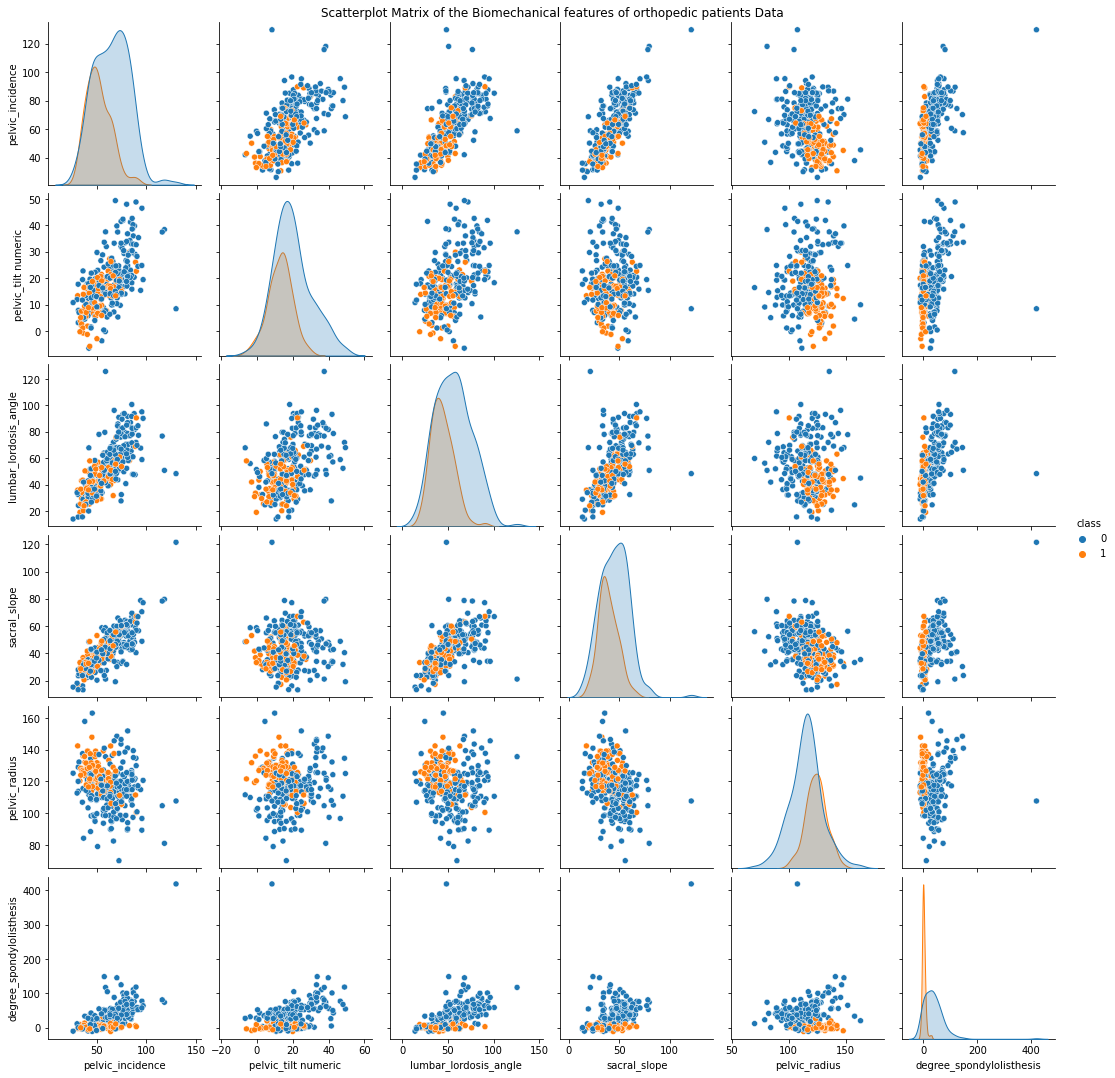

In [ ]:
def load_dataset_3():
    url = "https://raw.githubusercontent.com/1995hyz/Frequentist_ML/master/column_2C_weka.csv"
    df = pd.read_csv(url, sep=",")
    df['class'] = df['class'].astype('category').cat.codes
    return df

# Uncomment this line to randomize dataset.
df = load_dataset_3()
scatter_plot = seaborn.pairplot(df, hue = "class")
scatter_plot.fig. suptitle("Scatterplot Matrix of the Biomechanical features of orthopedic patients Data", y = 1)
plt.show()


BaseLine accuracy:  0.58064516129032258063
Test Accuracy with unregularized sgd:  0.6774193548387096
Optimal Lambda: 2.6826957952797164e-20
L2 Accuracy: 0.9032258064516129
Optimal Lambda for L1: 0.0
L1 Accuracy: 0.8709677419354839


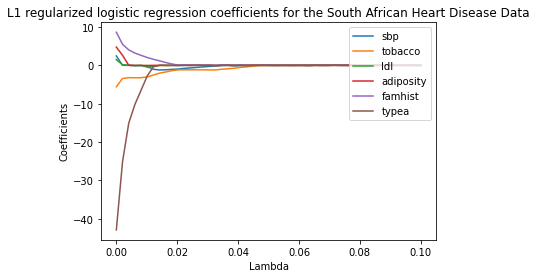

Select features: 
Index(['prefix', 'degree_spondylolisthesis'], dtype='object')
Forward-step regression:  0.5806451612903226
% correctness for different approach of logistic regression


,0
Baseline,0.580645
Unregularized,0.677419
with L2 penalty,0.903226
with L1 penalty,0.870968
Forward Stepwise,0.580645


In [ ]:
def logistic_regression_foward_step_2(data):
    data_train = data.get_data_train(False, "class")
    data_validation = data.get_data_validation(False, "class")
    # data_test = data.get_data_test(False, "chd")
    feature_header = list(data.column_name)
    feature_header.remove("class")
    feature_header.append("class")    # To make sure the label is at the end of the header list
    theta, feature_selected = sgd_stepwise(data_train, feature_header, learning_rate, n_epoch, data_validation)
    print("Select features: ")
    print(feature_selected)
    feature_unselected = pd.DataFrame(data=data_test[:, 0:-1], columns=(["prefix"]+feature_header[0:-1]))
    accuracy = accuracy_test(theta, np.array(feature_unselected[feature_selected]), data_test[:, -1])
    return accuracy
    
warnings.filterwarnings("ignore")
df = df.sample(frac=1, random_state=random.randint(0, 200)).reset_index().drop(labels=["index"], axis=1)
data = Data(df)
data_train = data.get_data_train(True, "class")
data_validation = data.get_data_validation(True, "class")
data_test = data.get_data_test(True, "class")
learning_rate = 0.04
n_epoch = 1500
baselineAccuracy = get_baseline(data_train, data_test)
theta = sgd_training(data_train, learning_rate, n_epoch)
accuracy = accuracy_test(theta, data_test[:, 0:-1], data_test[:, -1])
print("Test Accuracy with unregularized sgd: ", accuracy)
accuracyL2, thetaL2 = sgd_validation_L2(data_train, data_validation,learning_rate, n_epoch)
accuracyL1, lasso = logistic_regression_L1(data_train, data_validation, learning_rate, n_epoch)
accuracyStep = logistic_regression_foward_step_2(data)
print("Forward-step regression: ", accuracyStep)
approach = ['Baseline', 'Unregularized', 'with L2 penalty', 'with L1 penalty', 'Forward Stepwise']
correctness = [baselineAccuracy, accuracy, accuracyL2, accuracyL1,accuracyStep]
tableCorrectness = pd.DataFrame(correctness,approach)
print('% correctness for different approach of logistic regression')
#Create a table for all the % of correctness
display(tableCorrectness)

For our new dataset, we can see that unregularized accuracy is higher than baseline, along with even higher accuracies for L2 and L1. However, it seems forward stepwise's accuracy is very similar as baseline accuracy. 